<a href="https://colab.research.google.com/github/AndresMontesDeOca/Redes_Neuronales/blob/main/05_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiperceptrón con TF - Autos - Predicción
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/Redes_Neuronales/Fuentes/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/Redes_Neuronales/Data/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

################################################################
def plot_history(history, start_epoch=0, metrics=None):
    if isinstance(metrics, str):
        metrics = [metrics]

    if metrics is None:
        metrics = [x for x in history.history.keys() if x[:4] != 'val_']

    if len(metrics) == 0:
        print('No metrics to display.')
        return

    # Get the epochs and filter them starting from start_epoch
    x = history.epoch[start_epoch:]

    rows = 1
    cols = len(metrics)
    count = 0

    plt.figure(figsize=(12 * cols, 8))

    for metric in sorted(metrics):
        count += 1
        plt.subplot(rows, cols, count)
        plt.plot(x, history.history[metric][start_epoch:], label='Train')
        val_metric = f'val_{metric}'
        if val_metric in history.history.keys():
            plt.plot(x, history.history[val_metric][start_epoch:], label='Validation')
        plt.title(metric.capitalize())
        plt.legend()
    plt.show()
################################################################

Mounted at /content/drive/


In [2]:
# Definición de las funciones
################################################################
import keras.backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())
#############################################################################
def compile_model(new_model, loss, optimizer):
    new_model.compile(optimizer=optimizer, loss=loss, metrics=['mae', r2_score])
    print(new_model.summary())
    return new_model
#############################################################################
def MyModel(loss, optimizer, input_dim, output_dim):
    new_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(output_dim)
    ])
    return compile_model(new_model, loss, optimizer)
#############################################################################
def MyCallbacks(patience):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    return [early_stop]
#############################################################################

In [3]:
data = pd.read_csv(DATOS_DIR + 'AUTOS.csv')
data = data.select_dtypes(include=['number'])
# print(data.info())
# display(data.head())

data.fillna(data.mean(), inplace=True)
print(data.isnull().sum())

X = data.drop(['highway-mpg', 'price'], axis=1)
y = data[['highway-mpg', 'price']]
# display(X.head())
# display(y.head())

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
symboling            0
dtype: int64


In [4]:
# Parámetros
batch_size = 32

# División de los datos en conjuntos de entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True)

# Normalización de los datos
data_scaler, target_scaler = StandardScaler(), StandardScaler()
X_train = data_scaler.fit_transform(X_train)
X_valid = data_scaler.transform(X_valid)
y_train = target_scaler.fit_transform(y_train)
y_valid = target_scaler.transform(y_valid)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 5250 (20.51 KB)
Trainable params: 5250 (20.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


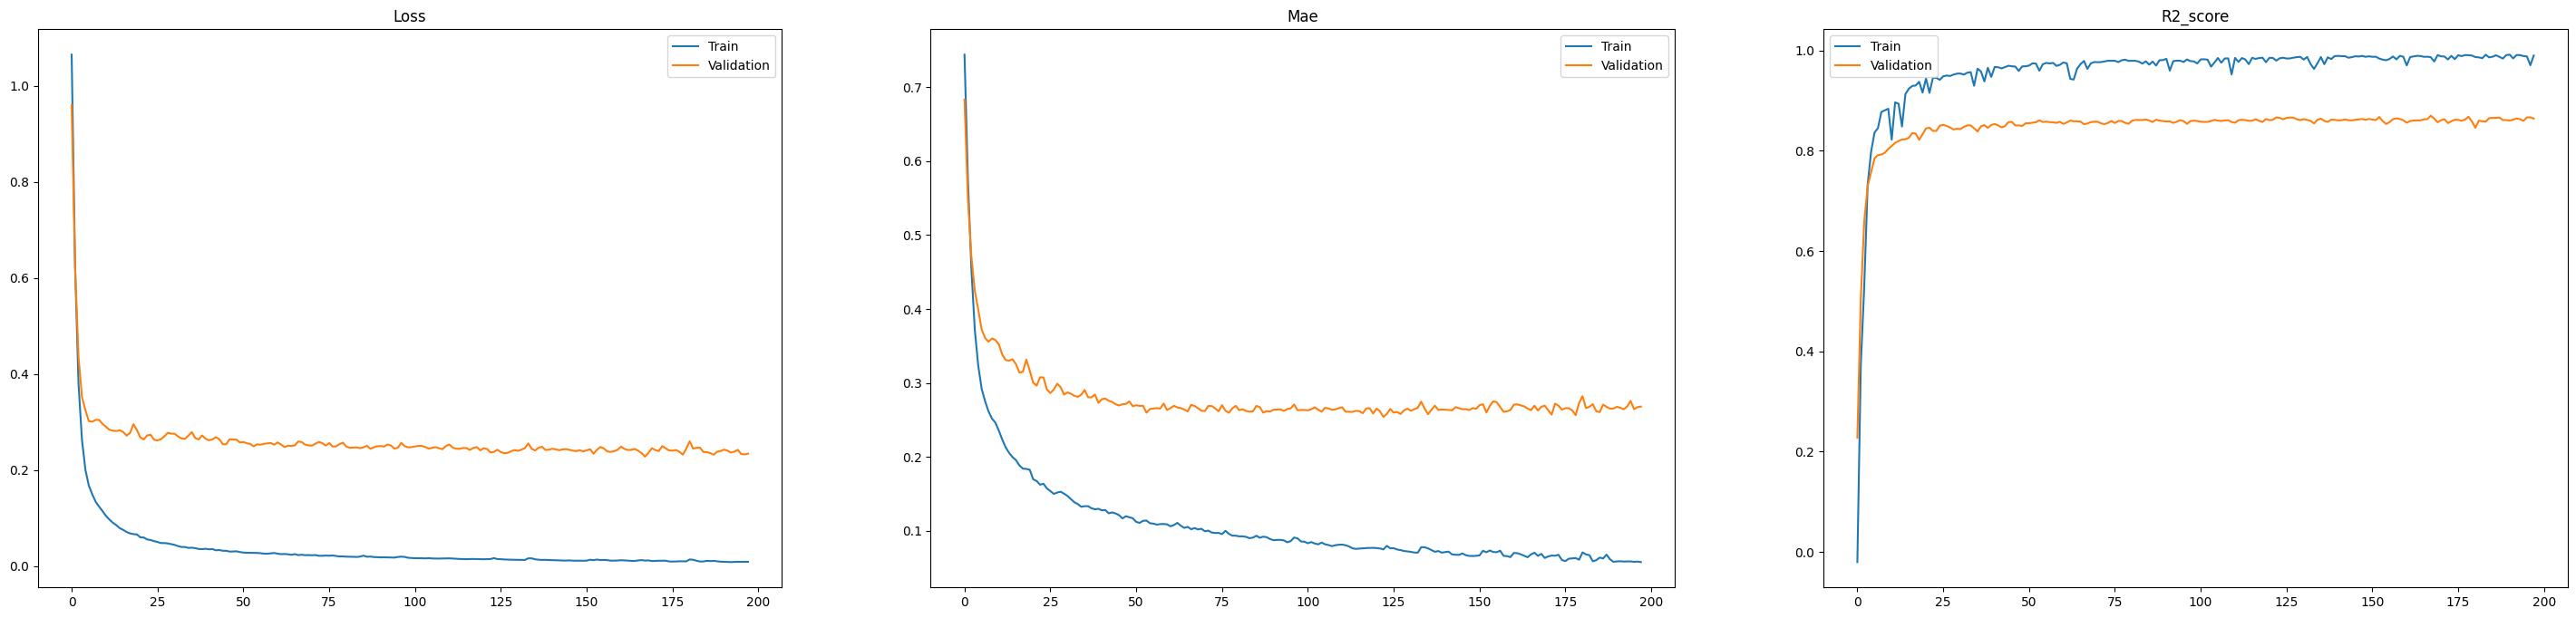

Number of epochs trained: 198


In [5]:
# Configuración del modelo
loss = 'mse'
optimizer = 'adam'
patience = 30
epochs = 1000
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

callbacks = MyCallbacks(patience)
model = MyModel(loss, optimizer, input_dim, output_dim)

# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks,
    verbose=0,
    epochs=epochs,
    batch_size=32
)

plot_history(history)

print("Number of epochs trained:", len(history.epoch))

**Carga del Dataset y selección de atributos numéricos**

In [6]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import chardet
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input

nombre_archivo = DATOS_DIR + 'AUTOS.csv'

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

df= pd.read_csv(nombre_archivo, encoding=result['encoding'])

#-- seleccionar los atributos numéricos --
df = df.select_dtypes(include = ["int16", "int32", "int64", "float16", "float32", "float64"])

**Asignar atributos sin valor o con valor nulo**

In [7]:
# muestra cantidad de valores faltantes o nulos por atributo/característica
print(df.isnull().sum())


values = {'normalized-losses': df['normalized-losses'].mean(),
          'bore': df['bore'].mean(),
          'stroke': df['stroke'].mean(),
          'horsepower': df['horsepower'].mean(),
          'peak-rpm': df['peak-rpm'].mean(),
          'price': df['price'].mean()}

# reemplaza valores nulos por los indicados en el diccionario values
df = df.fillna(value=values)

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
symboling             0
dtype: int64


**Normalización de valores de atributos y valores a predecir**

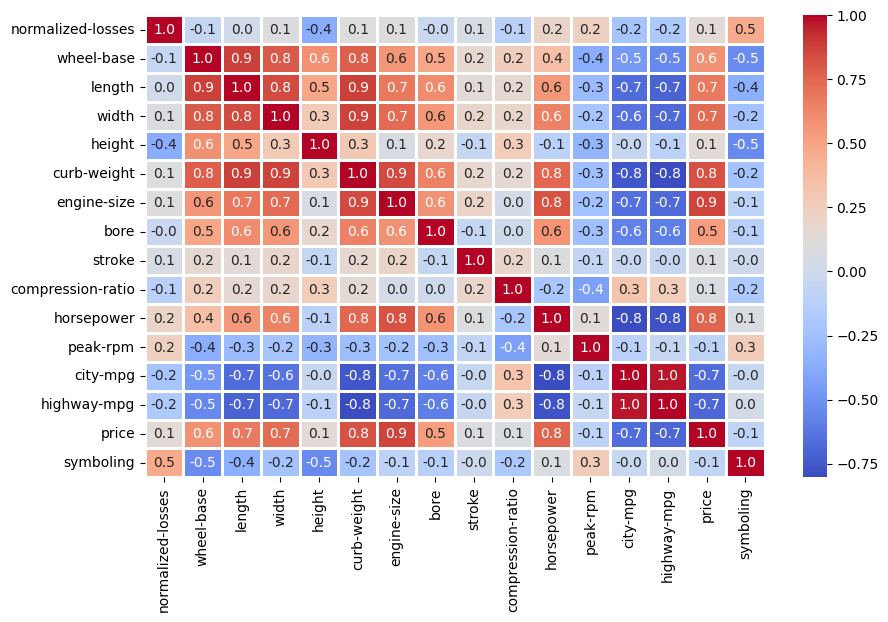

In [8]:
# Imprime matriz de correclacion
corr = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, square=False,  annot_kws={"size": 10}, annot=True, linewidths=.95, fmt='.1f', cmap='coolwarm')

datos = np.array(df)

attPred = [12,14] #12 mpg-highway y 14 precio  #-- nro de atributos a predecir
T = datos[:, attPred]
X = np.delete(datos, attPred, 1) # elimina columnas de atributos a predecir

# %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_test, y_train, y_test = train_test_split(X, T, test_size = 0.2,  shuffle = True)

data_scaler, target_scaler = StandardScaler(), StandardScaler()
x_train = data_scaler.fit_transform(x_train)
x_test = data_scaler.transform(x_test)
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

**Construccion del modelo y entrenamiento del modelo con parada temprana**

In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Tu código para cargar los datos y dividirlos en conjuntos de entrenamiento y validación
EPOCAS = 1000
TAM_LOTE = 64
ENTRADAS = X.shape[1]
SALIDAS = len(attPred)
PACIENCIA = 10
NUM_ENTRENAMIENTOS = 20  # Número de veces que se entrena cada modelo

ACTIVACIONES = ['tanh', 'relu', 'sigmoid', 'leaky_relu']
OPTIMIZADORES = ['adam']

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA)

resumen = {}
for ACTIVACION in ACTIVACIONES:
    for OPTIMIZADOR in OPTIMIZADORES:
        epocas = []
        medida_train = []

        print('\033[1mConfig %s + %s:\033[0m' % (ACTIVACION, OPTIMIZADOR))
        for i in range(NUM_ENTRENAMIENTOS):

            # Reorganiza al azar datos de entrenamiento
            x_train, x_test, y_train, y_test = train_test_split(X, T, test_size = 0.2,  shuffle = True)

            data_scaler, target_scaler = StandardScaler(), StandardScaler()
            x_train = data_scaler.fit_transform(x_train)
            x_test = data_scaler.transform(x_test)
            y_train = target_scaler.fit_transform(y_train)
            y_test = target_scaler.transform(y_test)

            print('\r      Train %2d/%2d' % (i+1, NUM_ENTRENAMIENTOS), end='')
            model = Sequential()
            model.add(Dense(8, activation=ACTIVACION, input_shape=[ENTRADAS]))
            model.add(Dense(4, activation=ACTIVACION))
            model.add(Dense(SALIDAS))

            model.compile(optimizer=OPTIMIZADOR, loss='mae', metrics=['mae', 'mse'])

            history = model.fit(
                x=x_train,
                y=y_train,
                batch_size=TAM_LOTE,
                epochs=EPOCAS,
                validation_data=(x_test, y_test),
                callbacks=[early_stop],
                verbose=0
            )

            epocas.append(len(history.epoch))
            y_pred = model.predict(x_train, verbose=0)
            r2_train = r2_score(y_train, y_pred)
            medida_train.append(r2_train)

            print(' -> epocas: %3d | r2: %7.5f' % (epocas[-1], medida_train[-1]))

        promedios = (np.mean(epocas), np.mean(medida_train))
        resumen[(ACTIVACION, OPTIMIZADOR)] = promedios
        print('Prom => epocas: %3d | r2: %7.5f\n' % promedios)


Config tanh + adam:
      Train  1/20 -> epocas: 219 | r2: 0.73385
      Train  2/20 -> epocas: 181 | r2: 0.75448
      Train  3/20 -> epocas: 480 | r2: 0.78621
      Train  4/20 -> epocas: 536 | r2: 0.88720
      Train  5/20 -> epocas: 361 | r2: 0.80048
      Train  6/20 -> epocas: 497 | r2: 0.84541
      Train  7/20 -> epocas: 356 | r2: 0.78096
      Train  8/20 -> epocas: 409 | r2: 0.83164
      Train  9/20 -> epocas: 337 | r2: 0.77151
      Train 10/20 -> epocas: 222 | r2: 0.78924
      Train 11/20 -> epocas: 152 | r2: 0.74438
      Train 12/20 -> epocas: 320 | r2: 0.75840
      Train 13/20 -> epocas: 167 | r2: 0.80821
      Train 14/20 -> epocas: 323 | r2: 0.82468
      Train 15/20 -> epocas: 299 | r2: 0.79270
      Train 16/20 -> epocas: 333 | r2: 0.81936
      Train 17/20 -> epocas: 260 | r2: 0.80773
      Train 18/20 -> epocas: 276 | r2: 0.75340
      Train 19/20 -> epocas: 221 | r2: 0.80971
      Train 20/20 -> epocas: 197 | r2: 0.76428
Prom => epocas: 307 | r2: 0.79319

Confi

KeyboardInterrupt: 

In [ ]:
# imprime resultados de forma amigable
formato = "|{:^12}|{:^12}|{:>12}|{:>18}|"
titulo =  formato.format("Activación", "Optimizador", "Prom. Epocas", "Prom. R2")

# Imprime encabezados
print("-" * len(titulo))
print(titulo)
print("-" * len(titulo))

# Imprime los resultados de forma agradable en columnas
for clave, valor in resumen.items():
    (activacion, optimizador), (epocas, r2) = clave, valor

    print(formato.format(activacion, optimizador, epocas, r2)) # Formatea y alinea valores en columnas

print("=" * len(titulo))


**Gráficos con evolución de curvas de error y accuracy**

In [ ]:

hist = history.history

def dibujar_curva(axs, value, epocas, hist):
    axs.plot(epocas, hist[value], label='Testeo')
    axs.plot(history.epoch, hist['val_'+value], label = 'Validacion')

    axs.set(xlabel="Epocas", ylabel=value)
    axs.legend()

fig, axs = plt.subplots(1,2, figsize=(20,6))

dibujar_curva(axs[0], 'mae', history.epoch, hist)
dibujar_curva(axs[1], 'mse', history.epoch, hist)

**Retroalimentación visual de las predicciones sobre los datos de validación**

In [ ]:
y_pred = model.predict(x_test)

y_test_no_norm = target_scaler.inverse_transform(y_test)
y_pred_no_norm = target_scaler.inverse_transform(y_pred)

fig, axs = plt.subplots(1,2, figsize=(20,6))

# lista con nro de iteracion
sample = list(range(len(y_test_no_norm)))

axs[0].plot(sample, y_test_no_norm[:,0],  "o", color='blue')
axs[0].plot(sample, y_pred_no_norm[:,0], "o", color='red')
axs[0].set(xlabel='Ejemplo', ylabel='Millas x galón')

axs[1].plot(sample, y_test_no_norm[:,1],  "o", color='blue')
axs[1].plot(sample, y_pred_no_norm[:,1], "o", color='red')
axs[1].set(xlabel='Ejemplo', ylabel='Precio del Vehículo')